In [2]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2, PDB_small
from MDAnalysis.analysis import distances,diffusionmap, align, rms,contacts,dihedrals, encore
from MDAnalysis.analysis.rms import RMSF
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from itertools import product
import timeit
import time
import math
import os.path
import seaborn as sns
import pandas as pd
import csv
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import scipy.signal as sig
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [3]:
path='/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/'
u_wta=mda.Universe(path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_wtb=mda.Universe(path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'wt_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_dma=mda.Universe(path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_dmb=mda.Universe(path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'dm_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_delP168a=mda.Universe(path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_delP168b=mda.Universe(path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'delP168_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

u_a173va=mda.Universe(path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainA_rep123.pr5.aligned_CA.not_waters.dcd')
u_a173vb=mda.Universe(path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters_or_ions.psf',path+'a173v_mpro_chainB_rep123.pr5.aligned_CA.not_waters.dcd')

In [4]:
def calc_l167_t169_hbond(u,title):
    
    def unit_vector(vector):
        return(vector/np.linalg.norm(vector))
    def angle_between(v1,v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return(math.degrees(np.arccos(np.clip(np.dot(v1_u,v2_u),-1.0,1.0))))
    
    dist=[]
    angle=[]
    hbond=[]
    l167o=u.select_atoms("resid 167 and name O")
    t169n=u.select_atoms("resid 169 and name N")
    t169h=u.select_atoms("resid 169 and name HN")
    for ts in u.trajectory:
        l167o_coor=u.select_atoms("resid 167 and name O").center_of_geometry()
        t169n_coor=u.select_atoms("resid 169 and name N").center_of_geometry()
        t169h_coor=u.select_atoms("resid 169 and name HN").center_of_geometry()
        dist1=np.min(distances.distance_array(l167o_coor,t169n_coor))
        dist.append((dist1))
        vec1=l167o_coor-t169h_coor
        vec2=t169n_coor-t169h_coor
        angle1=angle_between(vec1,vec2)
        angle.append(angle1)
        if dist1 < 4 and 120 < angle1 < 200:
            hbond.append(1)
        else:
            hbond.append(0)
    
    results=[]
    for i,j,k in zip(dist,angle,hbond):
        results.append((i,j,k))
    
    results=np.array(results).reshape(len(dist),3)
    
    with open('{}_l167_t169_hbond.npy'.format(title),'wb') as f:
        np.save(f,results)   
        
    print("Finished")
    
    return(results)

In [5]:
wta_hbond=calc_l167_t169_hbond(u_wta,"wt_chainA")
wtb_hbond=calc_l167_t169_hbond(u_wtb,"wt_chainB")

Finished
Finished


In [6]:
dma_hbond=calc_l167_t169_hbond(u_dma,"dm_chainA")
dmb_hbond=calc_l167_t169_hbond(u_dmb,"dm_chainB")

Finished
Finished


In [7]:
delP168a_hbond=calc_l167_t169_hbond(u_delP168a,"delP168_chainA")
delP168b_hbond=calc_l167_t169_hbond(u_delP168b,"delP168_chainB")

Finished
Finished


In [8]:
a173va_hbond=calc_l167_t169_hbond(u_a173va,"a173v_chainA")
a173vb_hbond=calc_l167_t169_hbond(u_a173vb,"a173v_chainB")

Finished
Finished


In [10]:
data_dir='/net/gpfs-amarolab/fiona/sars-cov-2/protease/'
wta_hbond=np.load(data_dir+'wt_chainA_l167_t169_hbond.npy')
wtb_hbond=np.load(data_dir+'wt_chainB_l167_t169_hbond.npy')
dma_hbond=np.load(data_dir+'dm_chainA_l167_t169_hbond.npy')
dmb_hbond=np.load(data_dir+'dm_chainB_l167_t169_hbond.npy')
delP168a_hbond=np.load(data_dir+'delP168_chainA_l167_t169_hbond.npy')
delP168b_hbond=np.load(data_dir+'delP168_chainB_l167_t169_hbond.npy')
a173va_hbond=np.load(data_dir+'a173v_chainA_l167_t169_hbond.npy')
a173vb_hbond=np.load(data_dir+'a173v_chainB_l167_t169_hbond.npy')

In [11]:
wt_all=np.concatenate((wta_hbond,wtb_hbond))
dm_all=np.concatenate((dma_hbond,dmb_hbond))
delP168_all=np.concatenate((delP168a_hbond,delP168b_hbond))
a173v_all=np.concatenate((a173va_hbond,a173vb_hbond))

In [12]:
def plot_distributions(wt,dm,delP168,a173v,title):
    params = {
         'font.family': 'sans-serif',
         'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
        
    dist_collection=wt[:,0].tolist()+dm[:,0].tolist()+delP168[:,0].tolist()+a173v[:,0].tolist()
    dist_start=np.min(dist_collection)-1
    dist_stop=np.max(dist_collection)+1
    angle_collection=wt[:,1].tolist()+dm[:,1].tolist()+delP168[:,1].tolist()+a173v[:,1].tolist()
    angle_start=np.min(angle_collection)-1
    angle_stop=np.max(angle_collection)+1
    
    domain_dist = np.linspace(dist_start,dist_stop,1000)
    dens_wt_dist = gaussian_kde(wt[:,0].tolist())
    dens_wt_dist.covariance_factor = lambda : 0.25
    dens_dm_dist = gaussian_kde(dm[:,0].tolist())
    dens_dm_dist.covariance_factor = lambda : 0.25
    dens_delP168_dist = gaussian_kde(delP168[:,0].tolist())
    dens_delP168_dist.covariance_factor = lambda : 0.25
    dens_a173v_dist = gaussian_kde(a173v[:,0].tolist())
    dens_a173v_dist.covariance_factor = lambda : 0.25
    
    domain_angle = np.linspace(angle_start,angle_stop,1000)
    dens_wt_angle = gaussian_kde(wt[:,1].tolist())
    dens_wt_angle.covariance_factor = lambda : 0.25
    dens_dm_angle = gaussian_kde(dm[:,1].tolist())
    dens_dm_angle.covariance_factor = lambda : 0.25
    dens_delP168_angle = gaussian_kde(delP168[:,1].tolist())
    dens_delP168_angle.covariance_factor = lambda : 0.25
    dens_a173v_angle = gaussian_kde(a173v[:,1].tolist())
    dens_a173v_angle.covariance_factor = lambda : 0.25
    
    #fig = plt.figure(figsize=(12,8))
    fig, axs = plt.subplots(1,2, sharex=False, sharey=False, tight_layout=True, figsize=(24,12))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    ## plot a_XXX's together
    p1, = axs[0].plot(domain_dist,dens_wt_dist(domain_dist),color='cornflowerblue',alpha=0.8,linewidth=4,label='WT') ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_wt_dist(domain_dist),color='cornflowerblue',alpha=0.2)
    p2, = axs[0].plot(domain_dist,dens_dm_dist(domain_dist),color='burlywood',alpha=0.8,linewidth=4,label='DM') ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_dm_dist(domain_dist),color='burlywood',alpha=0.2)
    p3, = axs[0].plot(domain_dist,dens_delP168_dist(domain_dist),color='peru',alpha=0.8,linewidth=4,label="$\Delta$P168") ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_delP168_dist(domain_dist),color='peru',alpha=0.2)
    p4, = axs[0].plot(domain_dist,dens_a173v_dist(domain_dist),color='saddlebrown',alpha=0.8,linewidth=4,label='A173V') ## column 2 = interface 1
    axs[0].fill_between(domain_dist,dens_a173v_dist(domain_dist),color='saddlebrown',alpha=0.2)
    axs[0].set_xlabel("HBond Distance ($\AA{}$)")
    axs[0].set_ylabel("Density")

    
    axs[1].plot(domain_angle,dens_wt_angle(domain_angle),color='cornflowerblue',alpha=0.8,linewidth=4,label='WT') ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_wt_angle(domain_angle),color='cornflowerblue',alpha=0.2)
    axs[1].plot(domain_angle,dens_dm_angle(domain_angle),color='burlywood',alpha=0.8,linewidth=4,label='DM') ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_dm_angle(domain_angle),color='burlywood',alpha=0.2)
    axs[1].plot(domain_angle,dens_delP168_angle(domain_angle),color='peru',alpha=0.8,linewidth=4,label="$\Delta$P168") ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_delP168_angle(domain_angle),color='peru',alpha=0.2)
    axs[1].plot(domain_angle,dens_a173v_angle(domain_angle),color='saddlebrown',alpha=0.8,linewidth=4,label='A173V') ## column 2 = interface 1
    axs[1].fill_between(domain_angle,dens_a173v_angle(domain_angle),color='saddlebrown',alpha=0.2)
    axs[1].set_xlabel("HBond Angle ($\degree$)")
    axs[1].set_ylabel("Density")

    
    
    #plt.title("Distribution of C145-S to H41-N Dist")
    #plt.ylabel("Density",labelpad=40)
    #plt.xlabel("C145-S to H41-N Dist ($\AA{}$)")
    
    
    plt.legend(fontsize=36)
    plt.legend(handles=[p1, p2, p3, p4],bbox_to_anchor=(0.75,-0.1),ncol=4,fontsize=36)
    fig.tight_layout()
    plt.savefig('{}_l167_t169_hbond.png'.format(title),bbox_inches='tight',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


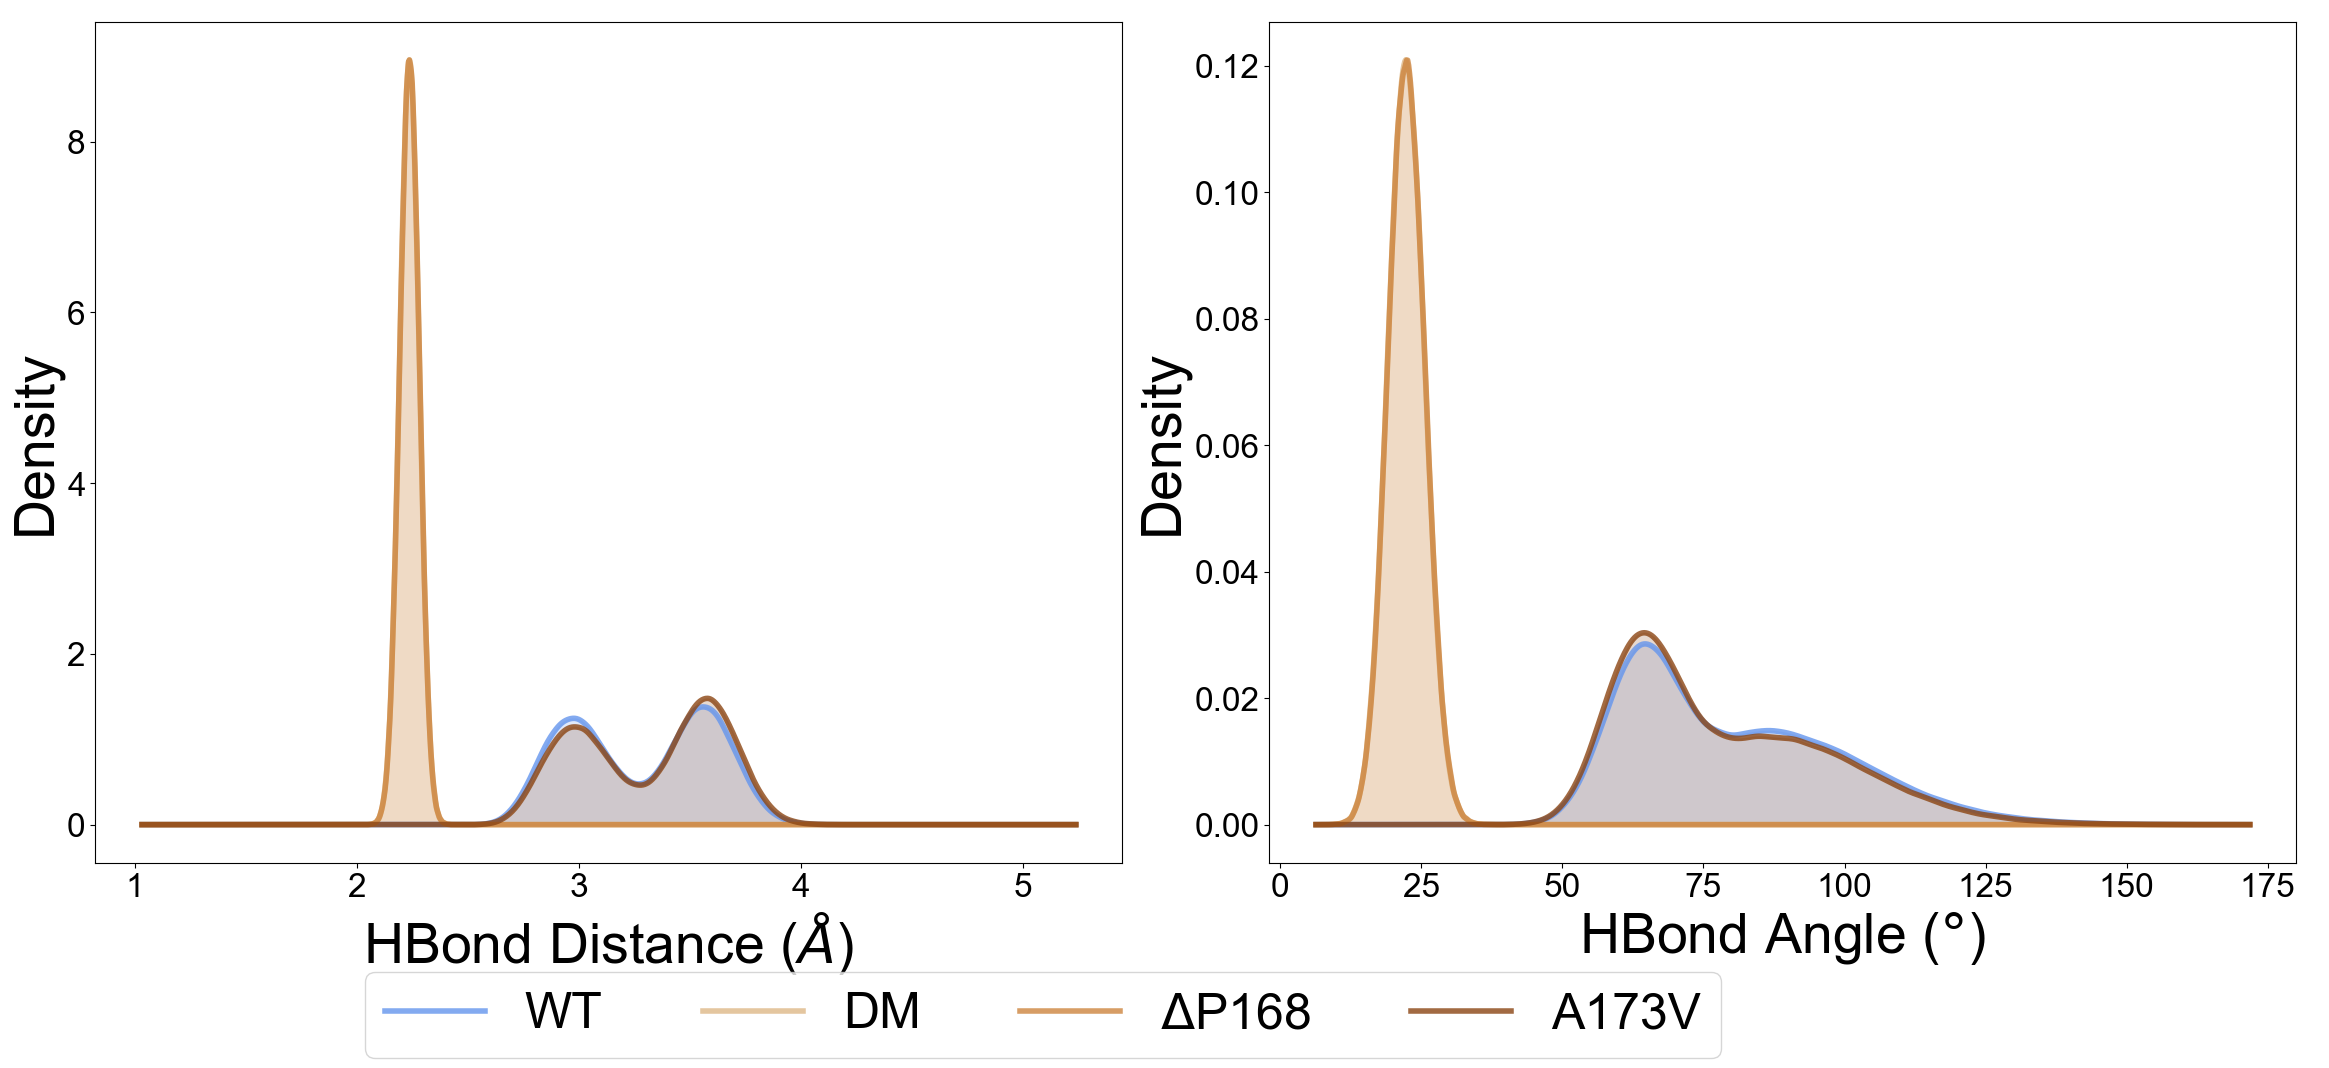

In [13]:
plot_distributions(wt_all,dm_all,delP168_all,a173v_all,"wt_dm_delP168_a173v_all")